# Merging SRXs

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs
from ncbi_remap.prealn_analysis import srr_per_srx, srx_reproducibility_score, SPEARMAN_CUTOFF
from ncbi_remap.normalization import cpm

# Setup notebook
nbconfig = Nb.setup_notebook('prealn-wf_merge_srr')

# Connect to data store
store = pd.HDFStore('../sra.h5')

# Start dask cluster
client = Client()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-06-27 
Git hash: 4c20d01e6681b8c7b88b8839bd26945d510a9c60


In [2]:
num_samples = '{:,}'.format(store['prealn/qc_passed'].shape[0])

Markdown(f"""
In the SRA, runs (SRR) are considered technical replicates. 
However, we have found instances where users have uploaded biological replicates or different samples as the same SRX. 
We want to provide browser tracks and summarized coverage counts at the library (SRX) level, requiring SRRs to be merged. 
Instead of blindly merging SRRs, we want to verify that SRRs within an SRX behave like a technical replicate. 
I am starting with the {num_samples} SRRs that passed all QC metrics.
I have explored multiple criteria (including SERE), but I have settled on using pairwise Spearman correlation. 
Here I require a correlation of ≥{SPEARMAN_CUTOFF} for an SRR to be considered a technical replicate. 
I also require that all SRRs within an SRX behave like technical replicates. 
There are cases where an SRX has 3 or more SRR with a small fraction behaving differently. 
Currently I am excluding these SRXs, but it may be worth while to try to create pseudo SRXs made up of these different groups of SRRs that behave similarly.
""")


In the SRA, runs (SRR) are considered technical replicates. 
However, we have found instances where users have uploaded biological replicates or different samples as the same SRX. 
We want to provide browser tracks and summarized coverage counts at the library (SRX) level, requiring SRRs to be merged. 
Instead of blindly merging SRRs, we want to verify that SRRs within an SRX behave like a technical replicate. 
I am starting with the 21,403 SRRs that passed all QC metrics.
I have explored multiple criteria (including SERE), but I have settled on using pairwise Spearman correlation. 
Here I require a correlation of ≥0.95 for an SRR to be considered a technical replicate. 
I also require that all SRRs within an SRX behave like technical replicates. 
There are cases where an SRX has 3 or more SRR with a small fraction behaving differently. 
Currently I am excluding these SRXs, but it may be worth while to try to create pseudo SRXs made up of these different groups of SRRs that behave similarly.


## Number of SRRs Per SRX

In [3]:
df = store['prealn/qc_passed'].groupby('srx').size().value_counts().to_frame()
df.index.name = 'Number of SRRs'
df.columns = ['Number of SRXs']

single = df.loc[1, 'Number of SRXs']
multi = df.iloc[1:, 0].sum()

Markdown(f"""
The majority of SRXs (n={single:,}) have a single SRR, while the remaining {multi:,} SRXs have more than one SRR that need to be merged.

{df.applymap(lambda x: '{:,}'.format(x)).to_html(classes="table table-striped")}
""")



The majority of SRXs (n=15,538) have a single SRR, while the remaining 1,874 SRXs have more than one SRR that need to be merged.

<table border="1" class="dataframe table table-striped">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Number of SRXs</th>
    </tr>
    <tr>
      <th>Number of SRRs</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>1</th>
      <td>15,538</td>
    </tr>
    <tr>
      <th>2</th>
      <td>984</td>
    </tr>
    <tr>
      <th>3</th>
      <td>315</td>
    </tr>
    <tr>
      <th>5</th>
      <td>248</td>
    </tr>
    <tr>
      <th>4</th>
      <td>200</td>
    </tr>
    <tr>
      <th>6</th>
      <td>73</td>
    </tr>
    <tr>
      <th>8</th>
      <td>38</td>
    </tr>
    <tr>
      <th>7</th>
      <td>6</td>
    </tr>
    <tr>
      <th>14</th>
      <td>3</td>
    </tr>
    <tr>
      <th>13</th>
      <td>3</td>
    </tr>
    <tr>
      <th>15</th>
      <td>1</td>
    </tr>
    <tr>
      <th>12</th>
      <td>1</td>
    </tr>
    <tr>
      <th>11</th>
      <td>1</td>
    </tr>
    <tr>
      <th>9</th>
      <td>1</td>
    </tr>
  </tbody>
</table>


## Calculate Correlations

In [4]:
@delayed
def calc_min_corr(srx):
    df = pd.read_parquet(f'../output/prealn-wf/gene_counts/{srx}.parquet')
    spearman = df.pivot(columns='srr', values='count').corr(method='spearman').min().min()
    return pd.DataFrame({'min_spearman': [spearman,]}, index=pd.Index([srx, ], name='srx'))

df = store['prealn/qc_passed'].groupby('srx').size()
srxs = df[df > 1].index.tolist()
lazy = [calc_min_corr(srx) for srx in srxs]
corrs = client.gather(client.compute(dd.from_delayed(lazy))).min_spearman

In [5]:
n_lt_cutoff = '{:,}'.format((corrs < SPEARMAN_CUTOFF).sum())
n_gt_cutoff = '{:,}'.format((corrs >= SPEARMAN_CUTOFF).sum())

Markdown(f"""
For each SRX with multiple SRRs I calculate the pairwise Spearman correlations among SRRs.
I then took the minimum spearman correlation among samples.
There are {n_lt_cutoff} samples whose minimum spearman correlation falls below {SPEARMAN_CUTOFF} and are therefore removed from analysis.
While there are {n_gt_cutoff} SRXs who pass merging criteria.
""")


For each SRX with multiple SRRs I calculate the pairwise Spearman correlations among SRRs.
I then took the minimum spearman correlation among samples.
There are 825 samples whose minimum spearman correlation falls below 0.95 and are therefore removed from analysis.
While there are 1,049 SRXs who pass merging criteria.


/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


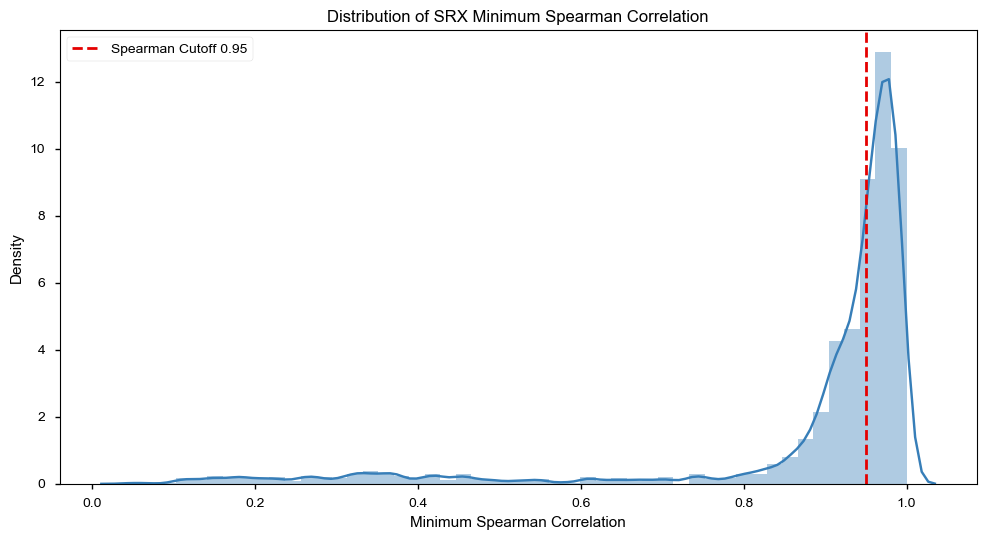

In [6]:
from ncbi_remap.prealn_analysis import SPEARMAN_CUTOFF

@make_figs(nbconfig.fig_name('distplot_spearman'), 
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def _plot():
    fig, ax = plt.subplots(1, 1)
    sns.distplot(corrs, ax=ax)
    ax.axvline(SPEARMAN_CUTOFF, color=nbconfig.color_c1, ls='--', lw=2, label=f'Spearman Cutoff {SPEARMAN_CUTOFF}')
    ax.set_xlabel('Minimum Spearman Correlation')
    ax.set_ylabel('Density')
    ax.set_title('Distribution of SRX Minimum Spearman Correlation')
    ax.legend()
    return fig

_plot()

In [7]:
ok_merge = corrs[corrs >= SPEARMAN_CUTOFF].index.tolist()

In [8]:
df = store['prealn/qc_passed'].groupby('srx').size()
singles = df[df == 1].index.tolist()

In [9]:
ok_srx = store['prealn/qc_passed'][store['prealn/qc_passed'].srx.isin(singles + ok_merge)]

In [10]:
store['prealn/merge_passed'] = ok_srx

In [11]:
store.close()